In [1]:
# from mlguess.keras.models import EvidentialRegressorDNN
# import keras
# import numpy as np
# from mlguess.keras.callbacks import ReportEpoch
# from mlguess.keras.losses import evidential_cat_loss, evidential_reg_loss
# from keras.models import load_model
# import matplotlib.pyplot as plt

# import pandas as pd
# import xarray as xr
# import glob
# from os.path import join
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
# from sklearn.model_selection import train_test_split
# # from dataloader import create_xy_data

In [2]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import SGD, Adam, RMSprop
# from keras.regularizers import l2
# from keras.callbacks import EarlyStopping
# import keras.backend as K
# from keras.models import Sequential
# from keras.layers import Dense, BatchNormalization, LeakyReLU
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [3]:
# from SALib.analyze import fast as fast_analyze
# from SALib.sample import fast_sampler
# from SALib.sample import saltelli
# from SALib.analyze import sobol

# from SALib.sample.sobol import sample as sobol_sample
# import warnings
# warnings.filterwarnings("ignore")

In [4]:
import sys
import os
project_dir = os.path.abspath("/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation")
#---------- Define paths for the specific subfolders
data_scripts_path = os.path.join(project_dir, "data_processing")
model_scripts_path = os.path.join(project_dir, "model")
#---------- Append the subfolder paths to sys.path
sys.path.append(data_scripts_path)
sys.path.append(model_scripts_path)

In [5]:
from packages import*

2025-04-09 12:22:58.123292: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 12:22:58.185679: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 12:22:59.273876: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from data_loader import x_input, y_input
# from global_mean import  global_mean
from spatial_ednn_model import evidential_regression_model

## Load Data

In [7]:
#---------- Compute CLM PPE season
clm_ppe_path ="/bsuhome/ksilwimba/scratch/NCAR/Data/LAI/TLAI"
djf_seas_tr, mam_seas_tr, jja_seas_tr, son_seas_tr = y_input(clm_ppe_path, start_year=1901, end_year=2000)
djf_seas_va, mam_seas_va, jja_seas_va, son_seas_va = y_input(clm_ppe_path, start_year=2000, end_year=2014)

In [8]:
conus_gridcells = list(range(50, 150))
djf_conus = djf_seas_tr.sel(gridcell=conus_gridcells)

In [9]:
djf_conus.TLAI[:,1:200]

<xarray.DataArray 'TLAI' (gridcell: 100, sample: 199)>
dask.array<getitem, shape=(100, 199), dtype=float32, chunksize=(100, 199), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object MultiIndex
  * member   (sample) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * time     (sample) object 1901-02-01 00:00:00 ... 1967-02-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

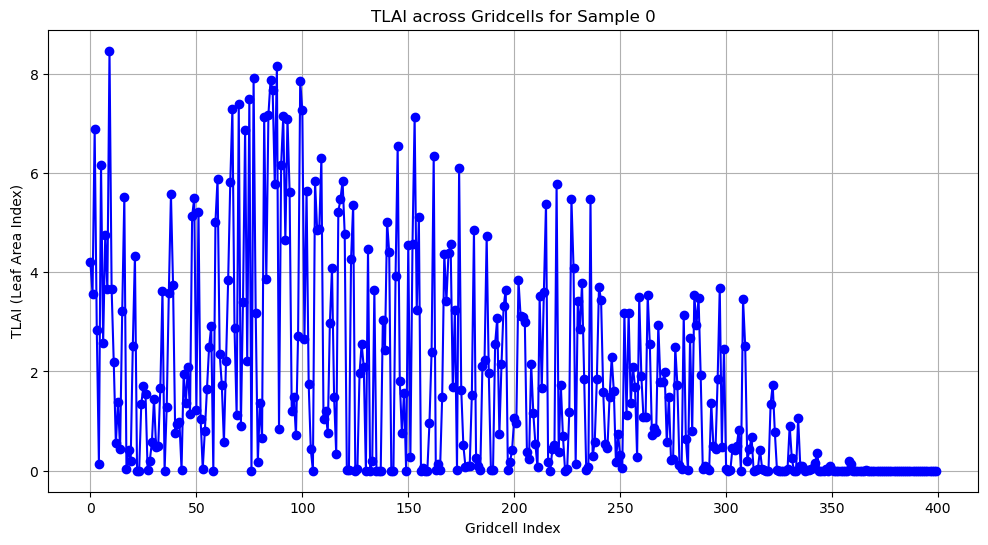

In [10]:

sample_index = 0
tlai_data = djf_seas_tr['TLAI'].isel(sample=sample_index)

# Plot TLAI values across grid cells
plt.figure(figsize=(12, 6))
plt.plot(tlai_data.gridcell, tlai_data, marker='o', linestyle='-', color='b')
plt.xlabel("Gridcell Index")
plt.ylabel("TLAI (Leaf Area Index)")
plt.title(f"TLAI across Gridcells for Sample {sample_index}")
plt.grid(True)
plt.show()


In [11]:
djf_seas_tr#.gridcell

<xarray.Dataset>
Dimensions:  (gridcell: 400, sample: 150000)
Coordinates:
  * sample   (sample) object MultiIndex
  * member   (sample) int64 1 1 1 1 1 1 1 1 ... 500 500 500 500 500 500 500 500
  * time     (sample) object 1901-01-01 00:00:00 ... 2000-12-01 00:00:00
Dimensions without coordinates: gridcell
Data variables:
    TLAI     (gridcell, sample) float32 dask.array<chunksize=(400, 1500), meta=np.ndarray>

In [12]:
djf_seas_tr.gridcell

<xarray.DataArray 'gridcell' (gridcell: 400)>
array([  0,   1,   2, ..., 397, 398, 399])
Dimensions without coordinates: gridcell

In [13]:
param_file_path = "/bsuhome/ksilwimba/scratch/NCAR/Data/helpers/lhc220926.txt"

#---------- Create x-train input
x_djf_tr, x_djf_tr_no_cyclic = x_input(djf_seas_tr, param_file_path)
x_mam_tr, x_mam_tr_no_cyclic = x_input(mam_seas_tr, param_file_path)
x_jja_tr, x_jja_tr_no_cyclic = x_input(jja_seas_tr, param_file_path)
x_son_tr, x_son_tr_no_cyclic = x_input(son_seas_tr, param_file_path)

#---------- Create x-train input
x_djf_va, x_djf_va_no_cyclic = x_input(djf_seas_va, param_file_path)
x_mam_va, x_mam_va_no_cyclic = x_input(mam_seas_va, param_file_path)
x_jja_va, x_jja_va_no_cyclic = x_input(jja_seas_va, param_file_path)
x_son_va, x_son_va_no_cyclic = x_input(son_seas_va, param_file_path)

In [14]:
djf_seas_tr

<xarray.Dataset>
Dimensions:  (gridcell: 400, sample: 150000)
Coordinates:
  * sample   (sample) object MultiIndex
  * member   (sample) int64 1 1 1 1 1 1 1 1 ... 500 500 500 500 500 500 500 500
  * time     (sample) object 1901-01-01 00:00:00 ... 2000-12-01 00:00:00
Dimensions without coordinates: gridcell
Data variables:
    TLAI     (gridcell, sample) float32 dask.array<chunksize=(400, 1500), meta=np.ndarray>

## Scale Data

#### Quantile Transformer 

In [15]:
#----------- Scaled x train and validation
scaler_x = QuantileTransformer(output_distribution='normal')
x_djf_tr_scaled = scaler_x.fit_transform(x_djf_tr)
x_mam_tr_scaled = scaler_x.fit_transform(x_mam_tr)
x_jja_tr_scaled = scaler_x.fit_transform(x_jja_tr)
x_son_tr_scaled = scaler_x.fit_transform(x_son_tr)

x_djf_va_scaled = scaler_x.transform(x_djf_va)
x_mam_va_scaled = scaler_x.transform(x_mam_va)
x_jja_va_scaled = scaler_x.transform(x_jja_va)
x_son_va_scaled = scaler_x.transform(x_son_va) 

In [16]:
#----------- Scaled x train and validation no cyclical encoding
scaler_x_no_cyclic = QuantileTransformer(output_distribution='normal')
x_djf_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_djf_tr_no_cyclic)
x_mam_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_mam_tr_no_cyclic)
x_jja_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_jja_tr_no_cyclic)
x_son_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_son_tr_no_cyclic)

x_djf_va_scaled_ = scaler_x_no_cyclic.transform(x_djf_va_no_cyclic)
x_mam_va_scaled_ = scaler_x_no_cyclic.transform(x_mam_va_no_cyclic)
x_jja_va_scaled_ = scaler_x_no_cyclic.transform(x_jja_va_no_cyclic)
x_son_va_scaled_ = scaler_x_no_cyclic.transform(x_son_va_no_cyclic) 

In [17]:
# #----------- Scaled x train and validation
# scaler_x = StandardScaler()
# x_djf_tr_scaled = scaler_x.fit_transform(x_djf_tr)
# x_mam_tr_scaled = scaler_x.fit_transform(x_mam_tr)
# x_jja_tr_scaled = scaler_x.fit_transform(x_jja_tr)
# x_son_tr_scaled = scaler_x.fit_transform(x_son_tr)


# x_djf_va_scaled = scaler_x.transform(x_djf_va)
# x_mam_va_scaled = scaler_x.transform(x_mam_va)
# x_jja_va_scaled = scaler_x.transform(x_jja_va)
# x_son_va_scaled = scaler_x.transform(x_son_va) 

In [18]:
# #----------- Scaled x train and validation no cyclical encoding
# scaler_x_no_cyclic = StandardScaler()
# x_djf_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_djf_tr_no_cyclic)
# x_mam_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_mam_tr_no_cyclic)
# x_jja_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_jja_tr_no_cyclic)
# x_son_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_son_tr_no_cyclic)


# x_djf_va_scaled_ = scaler_x_no_cyclic.transform(x_djf_va_no_cyclic)
# x_mam_va_scaled_ = scaler_x_no_cyclic.transform(x_mam_va_no_cyclic)
# x_jja_va_scaled_ = scaler_x_no_cyclic.transform(x_jja_va_no_cyclic)
# x_son_va_scaled_ = scaler_x_no_cyclic.transform(x_son_va_no_cyclic) 

In [19]:
# EvidentialRegressorDNN??

## EDNN Model 

In [20]:
# def evidential_regression_model(x_train, y_train, model_path, hidden_layers=3, batch_size=500,
#                                 n_output_tasks=400, epochs=10, loss_weight=0.01):
#     """
#     Trains an evidential regression model and saves it to the specified path.

#     Parameters:
#     - x_train: array-like, shape (n_samples, n_features)
#         Training input samples.
#     - y_train: array-like, shape (n_samples,) or (n_samples, n_output_tasks)
#         Target values.
#     - model_path: str
#         File path to save the trained model.
#     - hidden_layers: int, optional (default=3)
#         Number of hidden layers in the model.
#     - batch_size: int, optional (default=500)
#         Number of samples per gradient update.
#     - n_output_tasks: int, optional (default=400)
#         Number of output tasks.
#     - epochs: int, optional (default=10)
#         Number of epochs to train the model.
#     - loss_weight: float, optional (default=0.01)
#         Weight for the evidential regularization loss.

#     Returns:
#     - p_with_uncertainty: array-like
#         Predictions with uncertainty estimates.
#     - p_without_uncertainty: array-like
#         Predictions without uncertainty estimates.
#     - model: Keras Model
#         The trained evidential regression model.
#     - history: History object
#         Keras History object containing training history.
#     """
#     model = EvidentialRegressorDNN(hidden_layers=hidden_layers, n_output_tasks=n_output_tasks)
#     model.compile(loss=evidential_reg_loss(loss_weight), optimizer="adam")
#     history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
#     p_with_uncertainty = model.predict(x_train, return_uncertainties=True)
#     p_without_uncertainty = model.predict(x_train, return_uncertainties=False)
#     model.save(model_path)
#     print(f"Model successfully saved to: {model_path}")

#     return p_with_uncertainty, p_without_uncertainty, model, history



In [21]:
n_features = 35
n_output_tasks = 400

model_folder = "/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model"
model_path =  model_folder+"/sparse_djf_ednn_model.keras"

p_with_unc_djf, p_without_unc_djf, model_ednn_djf, history_djf = evidential_regression_model(
    x_djf_tr_scaled,
    djf_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.9959
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1162
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.3209
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.3945
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.4411
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.4905
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.5151
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.5863
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.6394
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.6652
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_djf_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/sav

In [22]:
model_path = model_folder+"/sparse_mam_ednn_model.keras"
p_with_unc_mam, p_without_unc_mam, model_ednn_mam, history_mam = evidential_regression_model(
    x_mam_tr_scaled,
    mam_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8393
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.3097
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.4984
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.5486
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.6103
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.6604
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.7346
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.8024
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.8328
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.8668
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_mam_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/sav

In [23]:
model_path = model_folder+"/sparse_jja_ednn_model.keras"
p_with_unc_jja, p_without_unc_jja, model_ednn_jja, history_jja = evidential_regression_model(
    x_jja_tr_scaled,
    jja_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2590
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2430
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1256
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0714
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0179
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.0115
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0585
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.0965
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1402
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.1709
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_jja_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_m

In [24]:
model_path = model_folder+"/sparse_son_ednn_model.keras"
p_with_unc_son, p_without_unc_son, model_ednn_son, history_son = evidential_regression_model(
    x_son_tr_scaled,
    son_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.2686
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2876
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0382
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0416
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.1204
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1605
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1976
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.2395
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.2628
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.2712
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_son_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved

FileNotFoundError: [Errno 2] No such file or directory: './Figures/TSgrid_mse_anom.pdf'

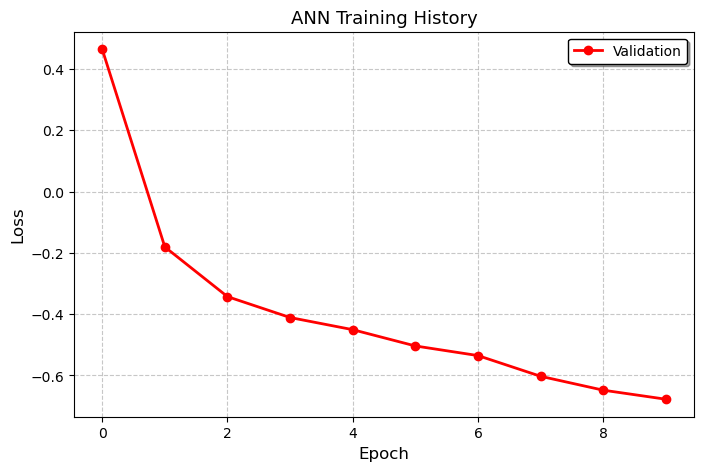

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(history_djf.epoch, history_djf.history['loss'], label='Validation', marker='o', linestyle='-', linewidth=2, color='red')
# plt.plot(history_djf.epoch, history_djf.history['mse'], label='Train', marker='o', linestyle='--', linewidth=2, color='blue')
plt.legend(shadow = True, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoch', fontsize=12)
plt.title('ANN Training History', fontsize=13)
plt.savefig("./Figures/TSgrid_mse_anom.pdf", bbox_inches='tight')
plt.show()

In [ ]:
sparse_pred_ednn_djf = model_ednn_djf.predict(x_djf_va_scaled)
sparse_pred_ednn_mam = model_ednn_mam.predict(x_mam_va_scaled)
sparse_pred_ednn_jja = model_ednn_jja.predict(x_jja_va_scaled)
sparse_pred_ednn_son = model_ednn_son.predict(x_son_va_scaled)

In [ ]:
#----------- Pred LAI
pred_djf_lai = sparse_pred_ednn_djf[:,:400]
pred_mam_lai = sparse_pred_ednn_mam[:,:400]
pred_jja_lai = sparse_pred_ednn_jja[:,:400]
pred_son_lai = sparse_pred_ednn_son[:,:400]

#---------- Aleatoric 
pred_djf_alea = sparse_pred_ednn_djf[:,400:800] 
pred_mam_alea = sparse_pred_ednn_mam[:,400:800] 
pred_jja_alea = sparse_pred_ednn_jja[:,400:800] 
pred_son_alea = sparse_pred_ednn_son[:,400:800] 

# #---------- Epistemic 
# pred_djf_epis = sparse_pred_ednn_djf[:,400:800] 
# pred_mam_epis = sparse_pred_ednn_mam[:,400:800] 
# pred_jja_epis = sparse_pred_ednn_jja[:,400:800] 
# pred_son_epis = sparse_pred_ednn_son[:,400:800] 

#---------- Epistemic 
pred_djf_epis = sparse_pred_ednn_djf[:,800:] 
pred_mam_epis = sparse_pred_ednn_mam[:,800:] 
pred_jja_epis = sparse_pred_ednn_jja[:,800:] 
pred_son_epis = sparse_pred_ednn_son[:,800:] 

In [ ]:
pred_djf_lai

In [ ]:
def regrid_to_lat_lon(data_array):
    """
    Regrids a given data array from a sparse grid to a standard latitude/longitude grid.
    
    It is recommended to perform any dimension-reducing calculations before calling this function to improve performance.
    
    Args:
    data_array (xarray.DataArray): The data array to regrid.
    
    Returns:
    xarray.DataArray: The data array regridded to standard latitude/longitude.
    """

    #---------------- Load the sparse grid information
    base_directory = '/bsuhome/ksilwimba/scratch/NCAR/Data/output_v4/'
    filename = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sparse_grid = xr.open_dataset(f'{base_directory}{filename}')
    
    #---------------- Determine the shape and coordinates for the output map
    output_shape = []
    coordinates = [] 
    
    #---------------- Include dimensions other than "gridcell" from the input data array
    for coord, size in zip(data_array.coords, data_array.shape):
        if size != 400:  # Assuming 400 is the gridcell count for the sparse grid
            output_shape.append(size)
            coordinates.append((coord, data_array[coord].values))
            
    #---------------- Include latitude and longitude from the sparse grid
    for coord in ['lat', 'lon']:
        size = len(sparse_grid[coord])
        output_shape.append(size)
        coordinates.append((coord, sparse_grid[coord].values))

    #---------------- Initialize the output array with NaNs
    output_array = np.full(output_shape, np.nan)
    
    #---------------- Fill the array with values from the input data array
    ds = xr.open_dataset('/bsuhome/ksilwimba/scratch/NCAR/Data/output_v4/PPEn11_transient_LHC0000.clm2.h0.2005-02-01-00000.nc')
    for i in range(400):  # Iterate over grid cells
        lat = ds.grid1d_lat[i]
        lon = ds.grid1d_lon[i]
        cluster_center = sparse_grid.rcent.sel(lat=lat, lon=lon, method='nearest')
        mask = sparse_grid.cclass == cluster_center
        
        if output_array.ndim == 2:
            output_array[mask] = data_array.isel(gridcell=i)
        else:
            num_matches = mask.sum().values
            output_array[:, mask] = np.tile(data_array.isel(gridcell=i).values[:, np.newaxis], [1, num_matches])
    
    #---------------- Create and return the output DataArray
    output_data_array = xr.DataArray(data=output_array, name=data_array.name, coords=coordinates)
    output_data_array.attrs = data_array.attrs

    return output_data_array


In [ ]:
########### Sparse Prediction
sparse_pred_ednn_djf = model_ednn_djf.predict(x_djf_va_scaled)
sparse_pred_ednn_mam = model_ednn_mam.predict(x_mam_va_scaled)
sparse_pred_ednn_jja = model_ednn_jja.predict(x_jja_va_scaled)
sparse_pred_ednn_son = model_ednn_son.predict(x_son_va_scaled)

In [ ]:
sparse_pred_ednn_djf[:,400]

In [ ]:
#------------------- Select CONUS region
us_lat_bounds = (25.031414,50)#(24.031414,49.47644)
us_lon_bounds = (233.75,293.75)

In [ ]:
#################### EDNN Covert and Regrid 
#---------- list of seasons
seasons = ['djf', 'mam', 'jja', 'son']
#---------- Map season names to their corresponding variables
seas_va = {
    'djf': djf_seas_va,
    'mam': mam_seas_va,
    'jja': jja_seas_va,
    'son': son_seas_va
}

pred_lai = {
    'djf': pred_djf_lai,
    'mam': pred_mam_lai,
    'jja': pred_jja_lai,
    'son': pred_son_lai
}

#---------- Initialize dictionaries to store the results
sparse_pred_ednn = {}
pred_ednn = {}

#----------  Loop over each season
for season in seasons:
    # Extract the coordinate data for the current season
    sample_coords = seas_va[season].sample.data
    member_coords = seas_va[season].member.data
    time_coords = seas_va[season].time.data

    #---------- Create the sparse prediction DataArray for the current season
    sparse_pred_ednn[season] = xr.DataArray(
        data=pred_lai[season],
        dims=['sample', 'gridcell'],
        coords=dict(
            sample=sample_coords,
            member=('sample', member_coords),
            time=('sample', time_coords)
        ),
        attrs={
            'long_name': 'total projected leaf area index',
            'units': '$m^2/m^2$',
            'cell_methods': 'time: mean'
        }
    )

    #---------- Regrid the sparse DataArray to standard latitude/longitude grid
    pred_ednn[season] = regrid_to_lat_lon(sparse_pred_ednn[season]).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
    
lat = pred_ednn['djf'].lat
lon = pred_ednn['djf'].lon

In [ ]:
djf_seas_va_clm = regrid_to_lat_lon(djf_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
mam_seas_va_clm = regrid_to_lat_lon(mam_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
jja_seas_va_clm = regrid_to_lat_lon(jja_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
son_seas_va_clm = regrid_to_lat_lon(son_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))

In [ ]:
lat

In [ ]:
sparse_pred_ednn_djf.shape

In [ ]:
# #---------- Aleatoric 
# pred_djf_alea = sparse_pred_ednn_djf[:,400:800] 
# pred_mam_alea = sparse_pred_ednn_mam[:,400:800] 
# pred_jja_alea = sparse_pred_ednn_jja[:,400:800] 
# pred_son_alea = sparse_pred_ednn_son[:,400:800] 

# #---------- Epistemic 
# pred_djf_epis = sparse_pred_ednn_djf[:,800:] 
# pred_mam_epis = sparse_pred_ednn_mam[:,800:] 
# pred_jja_epis = sparse_pred_ednn_jja[:,800:] 
# pred_son_epis = sparse_pred_ednn_son[:,800:] 

In [ ]:
#################### Epistemic Unvertainty Covert and Regrid 
#---------- list of seasons
seasons = ['djf', 'mam', 'jja', 'son']
#---------- Map season names to their corresponding variables
seas_va = {
    'djf': djf_seas_va,
    'mam': mam_seas_va,
    'jja': jja_seas_va,
    'son': son_seas_va
}

pred_alea = {
    'djf': pred_djf_alea,
    'mam': pred_mam_alea,
    'jja': pred_jja_alea,
    'son': pred_son_alea
}

#---------- Initialize dictionaries to store the results
sparse_pred_ednn_alea = {}
pred_ednn_alea = {}

#----------  Loop over each season
for season in seasons:
    # Extract the coordinate data for the current season
    sample_coords = seas_va[season].sample.data
    member_coords = seas_va[season].member.data
    time_coords = seas_va[season].time.data

    #---------- Create the sparse prediction DataArray for the current season
    sparse_pred_ednn_alea[season] = xr.DataArray(
        data=pred_alea[season],
        dims=['sample', 'gridcell'],
        coords=dict(
            sample=sample_coords,
            member=('sample', member_coords),
            time=('sample', time_coords)
        ),
        attrs={
            'long_name': 'Aleatoric Uncertainty',
            'units': '',
            'cell_methods': 'time: mean'
        }
    )

    #---------- Regrid the sparse DataArray to standard latitude/longitude grid
    pred_ednn_alea[season] = regrid_to_lat_lon(sparse_pred_ednn_alea[season]).sel(lat=slice(*us_lat_bounds),\
                                                                                   lon=slice(*us_lon_bounds))

In [ ]:
#################### Epistemic Unvertainty Covert and Regrid 
#---------- list of seasons
seasons = ['djf', 'mam', 'jja', 'son']
#---------- Map season names to their corresponding variables
seas_va = {
    'djf': djf_seas_va,
    'mam': mam_seas_va,
    'jja': jja_seas_va,
    'son': son_seas_va
}

pred_epis = {
    'djf': pred_djf_epis,
    'mam': pred_mam_epis,
    'jja': pred_jja_epis,
    'son': pred_son_epis
}

#---------- Initialize dictionaries to store the results
sparse_pred_ednn_epis = {}
pred_ednn_epis = {}

#----------  Loop over each season
for season in seasons:
    # Extract the coordinate data for the current season
    sample_coords = seas_va[season].sample.data
    member_coords = seas_va[season].member.data
    time_coords = seas_va[season].time.data

    #---------- Create the sparse prediction DataArray for the current season
    sparse_pred_ednn_epis[season] = xr.DataArray(
        data=pred_epis[season],
        dims=['sample', 'gridcell'],
        coords=dict(
            sample=sample_coords,
            member=('sample', member_coords),
            time=('sample', time_coords)
        ),
        attrs={
            'long_name': 'Epistemic Uncertainty',
            'units': '',
            'cell_methods': 'time: mean'
        }
    )

    #---------- Regrid the sparse DataArray to standard latitude/longitude grid
    pred_ednn_epis[season] = regrid_to_lat_lon(sparse_pred_ednn_epis[season]).sel(lat=slice(*us_lat_bounds),\
                                                                                   lon=slice(*us_lon_bounds))

In [ ]:
#===========Plotters
import cartopy as cart
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [ ]:
# #============Slicing CMIP6-mrsol US bounds
# us_lat_bounds = (26,49)#(24.031414,49.47644)
# us_lon_bounds = (233.75,293.75)

# path =  "/bsuhome/ksilwimba/scratch/SPMIP_Data"
# sm =  xr.open_dataset(path+'/CLM5_SPMIP_Exp1_1980-2010.nc').mrlsl
# mask = sm[0,0,:,:]/sm[0,0,:,:]

##############################

In [ ]:
# def EucDistance(x,y):
#     return np.sqrt((x - y)**2)


# =============================================================================
# 4. Euclidean Distance Function
# =============================================================================
def EucDistance(field1, field2):
    """
    Compute the pointwise Euclidean distance between two 2D fields of shape (lat, lon).

    Since sqrt((x - y)^2) = abs(x - y), each grid cell returns the absolute difference.

    Parameters
    ----------
    field1 : np.ndarray or xarray.DataArray
        First 2D array (lat, lon) representing EOF spatial patterns.
    field2 : np.ndarray or xarray.DataArray
        Second 2D array (lat, lon) to compare against field1.

    Returns
    -------
    distance : np.ndarray or xarray.DataArray
        A 2D array of shape (lat, lon) containing the pointwise Euclidean distance
        (i.e., absolute difference) for each grid cell.
    """
    return np.abs(field1 - field2)

#================EXP1
djf = EucDistance(djf_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['djf'][:, :].mean(dim="sample"))
mam = EucDistance(mam_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['mam'][:, :].mean(dim="sample"))
jja = EucDistance(jja_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['jja'][:, :].mean(dim="sample"))
son = EucDistance(son_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['son'][:, :].mean(dim="sample"))

In [ ]:
# Define a common geographic extent (lon_min, lon_max, lat_min, lat_max)
common_extent = [-125, -60, 25, 49]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12),  # square figure for equal subplots
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

for axis in ax.flat:
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    # Set the border color and width
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

def make_plot_without_contours(data_nc, ax, threshold, title, is_first_subplot=False, is_last_row=False):
    # Add cyclic point to data and longitude
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    # Make a filled plot without contours using pcolormesh with gouraud shading for smoothness
    mesh = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='YlOrBr', shading='gouraud')
    
    # Set title
    ax.set_title(title, fontweight='regular', fontsize=13, loc='left')
    
    # Create a mask for hatching based on threshold
    hatch_mask = np.ma.masked_less(data, threshold)
    ax.contourf(lons, lats, hatch_mask.mask, levels=[0.2, 3],
                colors='none', hatches=['//'], transform=ccrs.PlateCarree())
    
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    if is_first_subplot:
        ax.set_yticks(np.arange(24, 50, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
    # Add state boundaries
    states = cfeature.NaturalEarthFeature(category='cultural',
                                          name='admin_1_states_provinces_lines',
                                          scale='50m', facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    
    ax.minorticks_on()  # Enable minor ticks on both axes
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    
    return mesh

# Example data variables: djf, mam, jja, son and threshold
threshold = 0.2
mesh14a_ = make_plot_without_contours(djf, ax[0,0], threshold,
                                        '[a] EDNN DJF LAI EucD(CLM5_PPE -- EDNN_PPE)', is_first_subplot=True)
mesh14b_ = make_plot_without_contours(mam, ax[0,1], threshold,
                                        '[b] EDNN MAM LAI EucD(CLM5_PPE -- EDNN_PPE)')
mesh14c_ = make_plot_without_contours(jja, ax[1,0], threshold,
                                        '[c] EDNN JJA LAI EucD(CLM5_PPE -- EDNN_PPE)', is_first_subplot=True, is_last_row=True)
mesh14d_ = make_plot_without_contours(son, ax[1,1], threshold,
                                        '[d] EDNN SON LAI EucD(CLM5_PPE -- EDNN_PPE)', is_last_row=True)

# Create a single horizontal colorbar
fig.subplots_adjust(bottom=0.17, top=0.93)
cbar_ax = fig.add_axes([0.26, 0.12, 0.5,  0.03])
cbar = fig.colorbar(mesh14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Euclidean Distance', fontweight='regular', fontsize=10)

plt.savefig("./Figures/euclidean_dist.pdf", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
def make_plot_without_contours(data_nc, ax,threshold, title, is_first_subplot=False, is_last_row=False):
    #=================== Add cyclic point to data and longitude
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    #=================== Make a filled plot without contours using pcolormesh
    mesh = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='YlOrBr', shading='gouraud')
    
    # Set titles
    # ax.set_title(f"m$^2$/m$^2$", loc='right', fontweight='regular', size=10)
    ax.set_title(title, fontweight='regular', fontsize=13, loc='left')
    
#     #=================== Define the xticks for longitude and yticks for latitude
    hatch_mask = np.ma.masked_less(data, threshold)

    # Overlay hatches using contourf
    ax.contourf(lons, lats, hatch_mask.mask, levels=[0.2, 3],
                colors='none', hatches=['//'], transform=ccrs.PlateCarree())
    
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    if is_first_subplot:
        ax.set_yticks(np.arange(27, 48, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Add state boundaries
    states = cfeature.NaturalEarthFeature(category='cultural',
                                          name='admin_1_states_provinces_lines',
                                          scale='50m', facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    
    ax.minorticks_on()  # Enable minor ticks on both axes
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    
    return mesh



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8],
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       gridspec_kw={'wspace': 0.017, 'hspace': 0.01})

for axis in ax.flat:
    common_extent = [-125, -60, 25, 49]
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

#============================================ Spatial Maps 
threshold = 0.2
mesh14a_ = make_plot_without_contours(djf, ax[0,0],threshold,
                                        '[a] EDNN DJF LAI EucD(CLM5_PPE -- EDNN_PPE)', is_first_subplot=True)
mesh14b_ = make_plot_without_contours(mam, ax[0,1],threshold,
                                        '[b] EDNN MAM LAI EucD(CLM5_PPE -- EDNN_PPE)')
mesh14c_ = make_plot_without_contours(jja, ax[1,0], threshold,
                                        '[c] EDNN JJA LAI EucD(CLM5_PPE -- EDNN_PPE)', is_first_subplot=True, is_last_row=True)
mesh14d_ = make_plot_without_contours(son, ax[1,1], threshold,
                                        '[d] EDNN SON LAI EucD(CLM5_PPE -- EDNN_PPE)', is_last_row=True)

# Create a single horizontal colorbar
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(mesh14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Euclidean Distance', fontweight='regular', fontsize=10)

plt.savefig("./Figures/euclidean_dist.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from matplotlib.collections import QuadMesh
from typing import Any

def make_plot_without_contours(
    data_nc: Any,
    ax: Axes,
    threshold: float,
    title: str,
    is_first_subplot: bool = False,
    is_last_row: bool = False
) -> QuadMesh:
    """
    Create a filled pcolormesh plot with a hatch overlay for regions below a threshold.

    Parameters
    ----------
    data_nc : Any
        Input data array (or similar object) containing at least 'lat' and 'lon' coordinates.
    ax : Axes
        The matplotlib GeoAxes on which to plot.
    threshold : float
        The threshold below which hatch patterns are applied.
    title : str
        The title for the subplot.
    is_first_subplot : bool, optional
        If True, sets the y-tick labels (default is False).
    is_last_row : bool, optional
        If True, sets the x-tick labels (default is False).

    Returns
    -------
    QuadMesh
        The QuadMesh object created by pcolormesh.
    """
    # --- Add a cyclic point to avoid a gap in the map
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']

    # --- Create a 2D meshgrid of longitudes and latitudes
    lons2d, lats2d = np.meshgrid(lons, lats)

    # --- Create a filled pcolormesh plot
    mesh = ax.pcolormesh(
        lons2d,
        lats2d,
        data,
        transform=ccrs.PlateCarree(),
        cmap='YlOrBr',
        shading='gouraud'
    )

    # --- Set the subplot title
    ax.set_title(title, fontweight='regular', fontsize=13, loc='left')

    # --- Create a hatch mask for areas below the threshold
    hatch_mask = np.ma.masked_less(data, threshold)
    ax.contourf(
        lons,
        lats,
        hatch_mask.mask,
        levels=[0.2, 3],
        colors='none',
        hatches=['//'],
        transform=ccrs.PlateCarree()
    )

    # --- Configure x-ticks for the bottom row of subplots
    if is_last_row:
        xticks = np.arange(-120, -60, 10)
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())

    # --- Configure y-ticks for the first column of subplots
    if is_first_subplot:
        yticks = np.arange(26, 50, 5)
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

    # --- Add state and country boundaries
    states = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')

    # --- Enable minor ticks and add coastlines
    ax.minorticks_on()
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)

    return mesh

# --- Main plotting routine
if __name__ == '__main__':
    # Create a 2x2 figure with Cartopy PlateCarree projection
    fig, ax = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=[14,8],
        subplot_kw={'projection': ccrs.PlateCarree()},
        gridspec_kw={'wspace': 0.017, 'hspace': -0.2}
    )

    # Set a border around each subplot for visual clarity
    common_extent = [-125, -60, 25, 49]
    for axis in ax.flat:
        axis.set_extent(common_extent, crs=ccrs.PlateCarree())
        axis.spines['geo'].set_edgecolor('black')
        axis.spines['geo'].set_linewidth(2)

    # Define the threshold for hatching
    threshold = 0.2

    # Create spatial maps for different seasons (replace djf, mam, jja, son with your data)
    mesh14a = make_plot_without_contours(
        djf, ax[0, 0], threshold,
        '[a] EDNN DJF LAI EucD(CLM5_PPE -- EDNN_PPE)',
        is_first_subplot=True
    )
    mesh14b = make_plot_without_contours(
        mam, ax[0, 1], threshold,
        '[b] EDNN MAM LAI EucD(CLM5_PPE -- EDNN_PPE)'
    )
    mesh14c = make_plot_without_contours(
        jja, ax[1, 0], threshold,
        '[c] EDNN JJA LAI EucD(CLM5_PPE -- EDNN_PPE)',
        is_first_subplot=True,
        is_last_row=True
    )
    mesh14d = make_plot_without_contours(
        son, ax[1, 1], threshold,
        '[d] EDNN SON LAI EucD(CLM5_PPE -- EDNN_PPE)',
        is_last_row=True
    )

    # --- Adjust layout and add a horizontal colorbar
    fig.subplots_adjust(bottom=0.2, top=0.9)
    cbar_ax = fig.add_axes([0.26, 0.17, 0.5, 0.03])
    cbar = fig.colorbar(mesh14d, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Euclidean Distance', fontweight='regular', fontsize=10)

    # --- Save and display the figure
    plt.savefig("./Figures/euclidean_dist.pdf", dpi=600, bbox_inches='tight')
    plt.show()


################################################

In [ ]:
def _make_plot_without_contours_(data_nc, ax, title, is_first_subplot=False, is_last_row=False):
    #=================== Add cyclic point to data and longitude
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    #=================== Make a filled plot without contours using pcolormesh
    mesh = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='RdYlBu', shading='gouraud')
    
    # Set titles
    # ax.set_title(f"m$^2$/m$^2$", loc='right', fontweight='regular', size=10)
    ax.set_title(title, fontweight='regular', fontsize=13, loc='left')
    
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    if is_first_subplot:
        ax.set_yticks(np.arange(26, 49, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Add state boundaries
    states = cfeature.NaturalEarthFeature(category='cultural',
                                          name='admin_1_states_provinces_lines',
                                          scale='50m', facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    
    ax.minorticks_on()  # Enable minor ticks on both axes
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    # Create an inset axes using `ax.inset_axes`
    inset_ax = ax.inset_axes([.84, 0.13, 0.15, 0.29], transform=ax.transAxes)
    # Plot the distribution on the inset axes
    # Flatten the data and remove NaNs
    data_flat = data.flatten()
    data_flat = data_flat[~np.isnan(data_flat)]
    inset_ax.hist(
        data_flat, bins=30, color='g', edgecolor='black'
    )
    inset_ax.set_title('Distribution', fontsize=7)
    inset_ax.tick_params(axis='both', which='major', labelsize=7)
    inset_ax.set_ylabel('Density', fontsize=6)
    # Remove spines for a cleaner look
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)
    
    return mesh




fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 9],
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       gridspec_kw={'wspace': 0.017, 'hspace': -0.2})
common_extent = [-125, -60, 25, 49]
for axis in ax.flat:
    # Set the border color and width
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

#============================================ Spatial Maps 

mesh14a_ = _make_plot_without_contours_(pred_ednn['djf'][:, :].mean(dim="sample"), ax[0,0],
                                        '[a] EDNN DJF LAI (2000 - 2014)', is_first_subplot=True)
mesh14b_ = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"), ax[0,1],
                                        '[b] EDNN MAM LAI (2000 - 2014)')
mesh14c_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample"), ax[1,0],
                                        '[c] EDNN JJA LAI (2000 - 2014)', is_first_subplot=True, is_last_row=True)
mesh14d_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample"), ax[1,1],
                                        '[d] EDNN SON LAI (2000 - 2014)', is_last_row=True)

# Create a single horizontal colorbar
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.12, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(mesh14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=10)
plt.savefig("./Figures/Exp4TotalSM_SPMIP_Map.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
def _make_contour_plot_(data_nc, ax, title, is_first_subplot=False, is_last_row=False):
    #=================== Choose the Multi-model ensemble (MME) and week1 (time index of 0)
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])

    #=================== Make a filled contour plot
    cs = ax.contourf(lons, data_nc['lat'], data, transform=ccrs.PlateCarree(),
                               cmap='YlGnBu', extend='both')
#     ct = ax.contour(lons, data_nc['lat'], data, transform=ccrs.PlateCarree(),
#             colors='k', linewidths=0.5)
    
#     ax.clabel(ct, inline=True, fontsize=8, fmt="%d")
    # states = cfeature.NaturalEarthFeature(category='cultural',
    #                                   name='admin_1_states_provinces_lines',scale='50m',facecolor='none')
    # ax.add_feature(states, edgecolor='gray')
    # ax.set_title(title, fontweight='bold', fontsize=14, loc='right')
    # ax.set_title(f"m$^2$/m$^2$", loc='right', fontweight='regular', size=10)
        # Set longitude and latitude ticks
  
    ax.set_title(title, fontweight='regular', fontsize=12, loc='left')

#       #=================== Define the yticks for latitude
#     if is_last_row:
#         ax.set_xticks(np.arange(-170, 180, 40), crs=ccrs.PlateCarree())
#         lon_formatter = cticker.LongitudeFormatter()
#         ax.xaxis.set_major_formatter(lon_formatter)
        
#     if is_first_subplot:
#         ax.set_yticks(np.arange(lat.min(), lat.max(), 25), crs=ccrs.PlateCarree())
#         lat_formatter = cticker.LatitudeFormatter()
#         ax.yaxis.set_major_formatter(lat_formatter)
    # Define the yticks for latitude
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    if is_first_subplot:
        ax.set_yticks(np.arange(26, 50, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
   
    ax.minorticks_on()  # This would enable minor ticks on both axes
    ax.coastlines()
    # ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    # ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.add_feature(cfeature.COASTLINE)
    return cs




In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.017, 'hspace': -0.2})
for axis in ax.flat:
    # Set the border color and width
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)
#============================================ Spatial Maps 

cs14a_ = _make_plot_without_contours_(pred_ednn['djf'][:, :].mean(dim="sample") ,  ax[0,0], '[a] EDNN DJF LAI Annual Mean (2000 - 2014)', is_first_subplot=True)
cs14b_ = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample") ,  ax[0,1], '[b] EDNN MAM LAI Annual Mean (2000 - 2014)')
cs14c_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample") ,  ax[1,0], '[c] EDNN JJA LAI Annual Mean (2000 - 2014)', is_first_subplot=True, is_last_row=True)
cs14d_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample") ,  ax[1,1], '[d] EDNN SON LAI Annual Mean (2000 - 2014)', is_last_row=True)

# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=10)
plt.savefig("./Figures/conus_lai_.pdf", dpi = 600, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[15, 15], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.03,'hspace': -0.08})
for axis in ax.flat:
    # Set the border color and width
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)
    
#============================================ Spatial Maps 
cs1e = _make_plot_without_contours_(pred_ednn['djf'][:, :].mean(dim="sample"),    ax[0,0], '[a] EDNN DJF LAI (2000 - 2014) ', is_first_subplot=True)
cs11_ = _make_plot_without_contours_(djf_seas_va_clm[:, :].mean(dim="sample"),  ax[0,1], '[b] Ref. CLM5 DJF LAI (2000 - 2014)')
cs12_ = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"),   ax[1,0], '[c] EDNN MAM LAI (2000 - 2014)', is_first_subplot=True)
cs13_ = _make_plot_without_contours_(mam_seas_va_clm[:, :].mean(dim="sample"),  ax[1,1], '[d] Ref. CLM5 MAM LAI (2000 - 2014)')

cs14a_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample") ,  ax[2,0], '[d] EDNN JJA LAI (2000 - 2014)', is_first_subplot=True)
cs14b_ = _make_plot_without_contours_(jja_seas_va_clm[:, :].mean(dim="sample"),  ax[2,1], '[e] Ref. CLM5 JJA LAI (2000 - 2014)')
cs14c_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample"),   ax[3,0], '[f] EDNN SON LAI (2000 - 2014)', is_last_row=True, is_first_subplot=True)
cs14d_ = _make_plot_without_contours_(son_seas_va_clm[:, :].mean(dim="sample"),  ax[3,1], '[g] Ref. CLM5 SON LAI (2000 - 2014)', is_last_row=True)

# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.02])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Total Projected Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=10)
plt.savefig("./Figures/sparse_lai.pdf", dpi = 600, bbox_inches='tight')

In [ ]:
def _make_plot_without_contours_(data_nc, ax, title, is_first_subplot=False, is_last_row=False):
    #=================== Add cyclic point to data and longitude
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    #=================== Make a filled plot without contours using pcolormesh
    mesh = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='RdYlBu', shading='gouraud')
    
    # Set titles
    # ax.set_title(f"m$^2$/m$^2$", loc='right', fontweight='regular', size=10)
    ax.set_title(title, fontweight='regular', fontsize=13, loc='left')
    
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    if is_first_subplot:
        ax.set_yticks(np.arange(26, 50, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Add state boundaries
    states = cfeature.NaturalEarthFeature(category='cultural',
                                          name='admin_1_states_provinces_lines',
                                          scale='50m', facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    
    ax.minorticks_on()  # Enable minor ticks on both axes
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    # Create an inset axes using `ax.inset_axes`
    inset_ax = ax.inset_axes([.84, 0.13, 0.15, 0.29], transform=ax.transAxes)
    # Plot the distribution on the inset axes
    # Flatten the data and remove NaNs
    data_flat = data.flatten()
    data_flat = data_flat[~np.isnan(data_flat)]
    inset_ax.hist(
        data_flat, bins=30, color='g', edgecolor='black'
    )
    inset_ax.set_title('Distribution', fontsize=7)
    inset_ax.tick_params(axis='both', which='major', labelsize=7)
    inset_ax.set_ylabel('Density', fontsize=6)
    # Remove spines for a cleaner look
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)
    
    return mesh

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[20, 13.8], 
                       subplot_kw={'projection': ccrs.PlateCarree()}, 
                       gridspec_kw={'wspace': 0.02, 'hspace': -0.1})

for axis in ax.flat:
    # Set the border color and width
    # common_extent = [-125, -60, 25, 49]
    # axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

#============================================ Spatial Maps 
cs1e = _make_plot_without_contours_(pred_ednn['djf'][:, :].mean(dim="sample"),    ax[0,0], '[a] EDNN PPE DJF LAI Annual Mean (2000 - 2014) ', is_first_subplot=True)
cs11_ = _make_plot_without_contours_(djf_seas_va_clm[:, :].mean(dim="sample"),  ax[0,1], '[b] Ref. CLM5 PPE DJF LAI Annual Mean (2000 - 2014)')
cs12_ = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"),   ax[1,0], '[d] EDNN PPE MAM LAI Annual Mean (2000 - 2014)', is_first_subplot=True)
cs13_ = _make_plot_without_contours_(mam_seas_va_clm[:, :].mean(dim="sample"),  ax[1,1], '[e] Ref. CLM5 PPE MAM LAI Annual Mean (2000 - 2014)')

cs14a_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample") ,  ax[2,0], '[g] EDNN PPE JJA LAI Annual Mean (2000 - 2014)', is_first_subplot=True)
cs14b_ = _make_plot_without_contours_(jja_seas_va_clm[:, :].mean(dim="sample"),  ax[2,1], '[h] Ref. CLM5 PPE JJA LAI Annual Mean (2000 - 2014)')
cs14c_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample"),   ax[3,0], '[j] EDNN PPE SON LAI Annual Mean (2000 - 2014)', is_last_row=True, is_first_subplot=True)
cs14d_ = _make_plot_without_contours_(son_seas_va_clm[:, :].mean(dim="sample"),  ax[3,1], '[k] Ref. CLM5 PPE SON LAI Annual Mean (2000 - 2014)', is_last_row=True)

# Adding Euclidean Distance maps as the last column
threshold = .3
mesh14a_ = make_plot_without_contours(djf, ax[0,2], threshold,
                                        '[c] EDNN CLM5 PPE DJF LAI Euclidean Distance', is_first_subplot=False)
mesh14b_ = make_plot_without_contours(mam, ax[1,2], threshold,
                                        '[f] EDNN CLM5 PPE MAM LAI Euclidean Distance', is_first_subplot=False)
mesh14c_ = make_plot_without_contours(jja, ax[2,2], threshold,
                                        '[i] EDNN CLM5 PPE JJA LAI Euclidean Distance', is_first_subplot=False)
mesh14d_ = make_plot_without_contours(son, ax[3,2], threshold,
                                        '[l] EDNN CLM5 PPE SON LAI Euclidean Distance', is_first_subplot=False, is_last_row=True)

# Create a single horizontal colorbar
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax1 = fig.add_axes([0.16, 0.168, 0.45,  0.02])  # Define the position and size of the first colorbar axes
cbar1 = fig.colorbar(cs14d_, cax=cbar_ax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label('Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=12)

cbar_ax2 = fig.add_axes([0.65, 0.168, 0.25,  0.02])  # Define the position and size of the second colorbar axes
cbar2 = fig.colorbar(mesh14d_, cax=cbar_ax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label('Euclidean Distance', fontweight='regular', fontsize=12)

plt.savefig("./Figures/combined_figure.pdf", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# Create a 4 (seasons) x 3 (variables) grid of subplots.
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[20, 14], 
                       subplot_kw={'projection': ccrs.PlateCarree()}, 
                       gridspec_kw={'wspace': 0.017, 'hspace': -0.25})

# Set the border color and width for each subplot.
common_extent = [-125, -60, 25, 49]
for axis in ax.flat:
    # axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

#============================================ Spatial Maps 
cs1e   = _make_plot_without_contours_(pred_ednn['djf'][:, :].mean(dim="sample"),    ax[0,0], '[a] EDNN PPE LAI Annual Mean (2000 - 2014) ', is_first_subplot=True)
cs11_  = _make_plot_without_contours_(djf_seas_va_clm[:, :].mean(dim="sample"),  ax[0,1], '[b] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)')
cs12_  = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"),   ax[1,0], '[d] EDNN PPE LAI Annual Mean (2000 - 2014)', is_first_subplot=True)
cs13_  = _make_plot_without_contours_(mam_seas_va_clm[:, :].mean(dim="sample"),  ax[1,1], '[e] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)')

cs14a_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample"),   ax[2,0], '[g] EDNN PPE LAI Annual Mean (2000 - 2014)', is_first_subplot=True)
cs14b_ = _make_plot_without_contours_(jja_seas_va_clm[:, :].mean(dim="sample"),  ax[2,1], '[h] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)')
cs14c_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample"),   ax[3,0], '[j] EDNN PPE LAI Annual Mean (2000 - 2014)', is_last_row=True, is_first_subplot=True)
cs14d_ = _make_plot_without_contours_(son_seas_va_clm[:, :].mean(dim="sample"),  ax[3,1], '[k] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)', is_last_row=True)

# Adding Euclidean Distance maps as the last column
threshold = 0.3
mesh14a_ = make_plot_without_contours(djf, ax[0,2], threshold,
                                       '[c] EDNN CLM5 PPE LAI Euclidean Distance', is_first_subplot=False)
mesh14b_ = make_plot_without_contours(mam, ax[1,2], threshold,
                                       '[f] EDNN CLM5 PPE LAI Euclidean Distance', is_first_subplot=False)
mesh14c_ = make_plot_without_contours(jja, ax[2,2], threshold,
                                       '[i] EDNN CLM5 PPE LAI Euclidean Distance', is_first_subplot=False)
mesh14d_ = make_plot_without_contours(son, ax[3,2], threshold,
                                       '[l] EDNN CLM5 PPE LAI Euclidean Distance', is_first_subplot=False, is_last_row=True)

#------------------------------------------------------------------------
# Add season labels to the left-most subplot of each row.
# Adjust the coordinates (here, 0.02, 0.02 in axis coordinates) and fontsize as needed.
seasons = ['DJF', 'MAM', 'JJA', 'SON']
for i, season in enumerate(seasons):
    ax[i, 0].text(0.02, 0.02, season, transform=ax[i, 0].transAxes,
                  fontsize=16, fontweight='bold', va='bottom', ha='left', color='black')
#------------------------------------------------------------------------

# Adjust layout to leave space at the bottom for the colorbars.
fig.subplots_adjust(bottom=0.2, top=0.9)

# Create a horizontal colorbar for the LAI maps (first two columns).
cbar_ax1 = fig.add_axes([0.16, 0.19, 0.45,  0.02])
cbar1 = fig.colorbar(cs14d_, cax=cbar_ax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label('Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=12)

# Create a horizontal colorbar for the Euclidean Distance maps (last column).
cbar_ax2 = fig.add_axes([0.65, 0.19, 0.25,  0.02])
cbar2 = fig.colorbar(mesh14d_, cax=cbar_ax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label('Euclidean Distance', fontweight='regular', fontsize=12)
plt.savefig("./Figures/combined_figure.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create a 4 (seasons) x 3 (variables) grid of subplots.
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[20, 15], 
                       subplot_kw={'projection': ccrs.PlateCarree()}, 
                       gridspec_kw={'wspace': 0.03, 'hspace': -0.01})

# Set the border color and width for each subplot.
for axis in ax.flat:
    # axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

#============================================ Spatial Maps 
cs1e   = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"),    ax[0], '[a] EDNN PPE LAI Annual Mean (2000 - 2014) ', is_last_row=True,is_first_subplot=True)
cs11_  = _make_plot_without_contours_(mam_seas_va_clm[:, :].mean(dim="sample"),  ax[1], '[b] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)', is_last_row=True)
# cs12_  = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"),   ax[1,0], '[d] EDNN PPE LAI Annual Mean (2000 - 2014)', is_first_subplot=True)
# cs13_  = _make_plot_without_contours_(mam_seas_va_clm[:, :].mean(dim="sample"),  ax[1,1], '[e] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)')

# cs14a_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample"),   ax[2,0], '[g] EDNN PPE LAI Annual Mean (2000 - 2014)', is_first_subplot=True)
# cs14b_ = _make_plot_without_contours_(jja_seas_va_clm[:, :].mean(dim="sample"),  ax[2,1], '[h] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)')
# cs14c_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample"),   ax[3,0], '[j] EDNN PPE LAI Annual Mean (2000 - 2014)', is_last_row=True, is_first_subplot=True)
# cs14d_ = _make_plot_without_contours_(son_seas_va_clm[:, :].mean(dim="sample"),  ax[3,1], '[k] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)', is_last_row=True)

# Adding Euclidean Distance maps as the last column
threshold = 0.3
mesh14a_ = make_plot_without_contours(mam, ax[2], threshold,
                                       '[c] EDNN CLM5 PPE LAI Euclidean Distance', is_last_row=True, is_first_subplot=False)
# mesh14b_ = make_plot_without_contours(mam, ax[1,2], threshold,
#                                        '[f] EDNN CLM5 PPE LAI Euclidean Distance', is_first_subplot=False)
# mesh14c_ = make_plot_without_contours(jja, ax[2,2], threshold,
#                                        '[i] EDNN CLM5 PPE LAI Euclidean Distance', is_first_subplot=False)
# mesh14d_ = make_plot_without_contours(son, ax[3,2], threshold,
#                                        '[l] EDNN CLM5 PPE LAI Euclidean Distance', is_first_subplot=False, is_last_row=True)

#------------------------------------------------------------------------
# Add season labels to the left-most subplot of each row.
# Adjust the coordinates (here, 0.02, 0.02 in axis coordinates) and fontsize as needed.
seasons = ['MAM']#, 'MAM', 'JJA', 'SON']
for i, season in enumerate(seasons):
    ax[i].text(0.02, 0.02, season, transform=ax[i].transAxes,
                  fontsize=16, fontweight='bold', va='bottom', ha='left', color='black')
#------------------------------------------------------------------------

# Adjust layout to leave space at the bottom for the colorbars.
fig.subplots_adjust(bottom=0.2, top=0.9)

# Create a horizontal colorbar for the LAI maps (first two columns).
cbar_ax1 = fig.add_axes([0.15, 0.43, 0.47,  0.02])
cbar1 = fig.colorbar(cs1e, cax=cbar_ax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label('Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=10)
# Create a horizontal colorbar for the Euclidean Distance maps (last column).
cbar_ax2 = fig.add_axes([0.65, 0.43, 0.25,  0.02])
cbar2 = fig.colorbar(mesh14d_, cax=cbar_ax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label('Euclidean Distance', fontweight='regular', fontsize=10)

plt.savefig("./Figures/mam_combined_figure.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
from matplotlib.colors import LogNorm

def uncert_plot_without_contours_(data_nc, ax, title, is_first_subplot=False, is_last_row=False, norm=None):
    #=================== Add cyclic point to data and longitude
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    #=================== Make a filled plot without contours using pcolormesh
    mesh = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='coolwarm', shading='gouraud', norm=norm) #YlOrRd 
    
    # Set titles
    ax.set_title(title, fontweight='regular', fontsize=10, loc='left')
    
#     #=================== Define the yticks for latitude
#     if is_last_row:
#         ax.set_xticks(np.arange(-170, 180, 40), crs=ccrs.PlateCarree())
#         lon_formatter = cticker.LongitudeFormatter()
#         ax.xaxis.set_major_formatter(lon_formatter)
        
#     if is_first_subplot:
#         ax.set_yticks(np.arange(lats.min(), lats.max(), 25), crs=ccrs.PlateCarree())
#         lat_formatter = cticker.LatitudeFormatter()
#         ax.yaxis.set_major_formatter(lat_formatter)
    # Define the yticks for latitude
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    if is_first_subplot:
        ax.set_yticks(np.arange(26, 49, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

    states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_lines',
                                      scale='50m', facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.minorticks_on()  # This would enable minor ticks on both axes
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    
    return mesh

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8],
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       gridspec_kw={'wspace': 0.02, 'hspace': -0.18})
for axis in ax.flat:
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

log_norm = LogNorm(vmin=1e-2, vmax=1e2)

#============================================ Spatial Maps 

mesh14a_ = uncert_plot_without_contours_(pred_ednn_alea['djf'][:, :].mean(dim="sample"), ax[0,0], 
                             '[a] EDNN DJF Aleatoric Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
mesh14b_ = uncert_plot_without_contours_(pred_ednn_alea['mam'][:, :].mean(dim="sample"), ax[0,1], 
                             '[b] EDNN MAM  Aleatoric Uncertainty (2000 - 2014)', norm=log_norm)
mesh14c_ = uncert_plot_without_contours_(pred_ednn_alea['jja'][:, :].mean(dim="sample"), ax[1,0], 
                             '[c] EDNN JJA  Aleatoric Uncertainty  (2000 - 2014)', is_first_subplot=True, is_last_row=True, norm=log_norm)
mesh14d_ = uncert_plot_without_contours_(pred_ednn_alea['son'][:, :].mean(dim="sample"), ax[1,1], 
                             '[d] EDNN SON  Aleatoric Uncertainty  (2000 - 2014)', is_last_row=True, norm=log_norm)

fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(mesh14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=10)
plt.savefig("./Figures/aleatoric_map.pdf", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.02, 'hspace': -0.18})
for axis in ax.flat:
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

log_norm = LogNorm(vmin=1e-2, vmax=1e1)

#============================================ Spatial Maps 

cs14a_ = uncert_plot_without_contours_(pred_ednn_alea['djf'][:, :].mean(dim="sample"), ax[0,0], 
                             '[a] EDNN DJF Aleatoric Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14b_ = uncert_plot_without_contours_(pred_ednn_alea['mam'][:, :].mean(dim="sample"), ax[0,1], 
                             '[b] EDNN MAM  Aleatoric Uncertainty (2000 - 2014)', norm=log_norm)
cs14c_ = uncert_plot_without_contours_(pred_ednn_alea['jja'][:, :].mean(dim="sample"), ax[1,0], 
                             '[c] EDNN JJA  Aleatoric Uncertainty  (2000 - 2014)', is_first_subplot=True, is_last_row=True, norm=log_norm)
cs14d_ = uncert_plot_without_contours_(pred_ednn_alea['son'][:, :].mean(dim="sample"), ax[1,1], 
                             '[d] EDNN SON  Aleatoric Uncertainty  (2000 - 2014)', is_last_row=True, norm=log_norm)

fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=10)
plt.savefig("./Figures/aleatoric_map.pdf", dpi=600, bbox_inches='tight')

In [ ]:
# Now apply this modified function to your plot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=[10, 15], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.08, 'hspace': 0.13})

for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# Use LogNorm for log scaling
log_norm = LogNorm(vmin=1e-2, vmax=1e2)

#============================================ Spatial Maps 
cs14a_ = uncert_plot_without_contours_(pred_ednn_epis['djf'][:, :].mean(dim="sample"), ax[0], 
                              '[a] EDNN  DJF Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14b_ = uncert_plot_without_contours_(pred_ednn_epis['mam'][:, :].mean(dim="sample"), ax[1], 
                              '[b] EDNN MAM Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14c_ = uncert_plot_without_contours_(pred_ednn_epis['jja'][:, :].mean(dim="sample"), ax[2], 
                              '[c] EDNN JJA Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True,  norm=log_norm)
cs14d_ = uncert_plot_without_contours_(pred_ednn_epis['son'][:, :].mean(dim="sample"), ax[3], 
                              '[d] EDNN SON Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, is_last_row=True,  norm=log_norm)

# Create a single horizontal colorbar
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.16, 0.5,  0.017])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)

# Add colorbar label with units and mention the log scale
cbar.set_label('Epistemic Uncertainty', fontweight='regular', fontsize=10)

# Save the figure
plt.savefig("./Figures/epistemic_Map.pdf", dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=[10, 15], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.08, 'hspace': 0.13})
for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

log_norm = LogNorm(vmin=1e-2, vmax=1e1)

#============================================ Spatial Maps 

cs14a_ = uncert_plot_without_contours_(pred_ednn_alea['djf'][:, :].mean(dim="sample"), ax[0], 
                             '[a] EDNN DJF Aleatoric Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14b_ = uncert_plot_without_contours_(pred_ednn_alea['mam'][:, :].mean(dim="sample"), ax[1], 
                             '[b] EDNN MAM  Aleatoric Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14c_ = uncert_plot_without_contours_(pred_ednn_alea['jja'][:, :].mean(dim="sample"), ax[2], 
                             '[c] EDNN JJA  Aleatoric Uncertainty  (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14d_ = uncert_plot_without_contours_(pred_ednn_alea['son'][:, :].mean(dim="sample"), ax[3], 
                             '[d] EDNN SON  Aleatoric Uncertainty  (2000 - 2014)', is_first_subplot=True, is_last_row=True, norm=log_norm)
plt.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.16, 0.5,  0.017])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=10)
plt.savefig("./Figures/aleatoric_map.pdf", dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=[10, 15], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.08, 'hspace': 0.13})
for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

log_norm = LogNorm(vmin=1e-2, vmax=1e1)

#============================================ Spatial Maps 

cs14a_ = uncert_plot_without_contours_(pred_ednn_alea['djf'][:, :].mean(dim="sample"), ax[0], 
                             '[a] EDNN DJF Aleatoric Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14b_ = uncert_plot_without_contours_(pred_ednn_alea['mam'][:, :].mean(dim="sample"), ax[1], 
                             '[b] EDNN MAM  Aleatoric Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14c_ = uncert_plot_without_contours_(pred_ednn_alea['jja'][:, :].mean(dim="sample"), ax[2], 
                             '[c] EDNN JJA  Aleatoric Uncertainty  (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14d_ = uncert_plot_without_contours_(pred_ednn_alea['son'][:, :].mean(dim="sample"), ax[3], 
                             '[d] EDNN SON  Aleatoric Uncertainty  (2000 - 2014)', is_first_subplot=True, is_last_row=True, norm=log_norm)
plt.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.16, 0.5,  0.017])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=10)
plt.savefig("./Figures/aleatoric_map.pdf", dpi=600, bbox_inches='tight')



# Now apply this modified function to your plot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=[10, 15], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.08, 'hspace': 0.13})

for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# Use LogNorm for log scaling
log_norm = LogNorm(vmin=1e-2, vmax=1e2)

#============================================ Spatial Maps 
cs14a_ = uncert_plot_without_contours_(pred_ednn_epis['djf'][:, :].mean(dim="sample"), ax[0], 
                              '[a] EDNN  DJF Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14b_ = uncert_plot_without_contours_(pred_ednn_epis['mam'][:, :].mean(dim="sample"), ax[1], 
                              '[b] EDNN MAM Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14c_ = uncert_plot_without_contours_(pred_ednn_epis['jja'][:, :].mean(dim="sample"), ax[2], 
                              '[c] EDNN JJA Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True,  norm=log_norm)
cs14d_ = uncert_plot_without_contours_(pred_ednn_epis['son'][:, :].mean(dim="sample"), ax[3], 
                              '[d] EDNN SON Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, is_last_row=True,  norm=log_norm)

# Create a single horizontal colorbar
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.16, 0.5,  0.017])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)

# Add colorbar label with units and mention the log scale
cbar.set_label('Epistemic Uncertainty', fontweight='regular', fontsize=10)

# Save the figure
plt.savefig("./Figures/epistemic_Map.pdf", dpi=600, bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm

# Define font sizes for the subplot titles and the season labels.
title_fontsize = 30         # Increase this value to enlarge subplot titles.
season_label_fontsize = 16  # Font size for the season label text

# Create a 4 (seasons) x 2 (uncertainty types) grid of subplots.
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 12),
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       gridspec_kw={'wspace': -0.01, 'hspace': 0.14})

# Set the Cartopy frame (the "geo" spines) for each subplot.
for axis in ax.flat:
    # axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# Define normalization for each uncertainty type.
norm_alea = LogNorm(vmin=1e-2, vmax=1e1)   # for aleatoric uncertainty
norm_epi  = LogNorm(vmin=1e-2, vmax=1e2)     # for epistemic uncertainty

# Define the seasons and corresponding subplot titles.
seasons = ['djf', 'mam', 'jja', 'son']
titles_alea = [
    '[a] EDNN Aleatoric Uncertainty (2000 - 2014)',
    '[c] EDNN Aleatoric Uncertainty (2000 - 2014)',
    '[e] EDNN Aleatoric Uncertainty (2000 - 2014)',
    '[g] EDNN Aleatoric Uncertainty (2000 - 2014)'
]
titles_epi = [
    '[b] EDNN Epistemic Uncertainty (2000 - 2014)',
    '[d] EDNN Epistemic Uncertainty (2000 - 2014)',
    '[f] EDNN Epistemic Uncertainty (2000 - 2014)',
    '[h] EDNN Epistemic Uncertainty (2000 - 2014)'
]

# Loop over each season and plot the corresponding data.
for i, season in enumerate(seasons):
    # Mark the last row to allow extra formatting if needed.
    is_last = (i == len(seasons) - 1)
    
    # Left column: aleatoric uncertainty.
    cs_alea = uncert_plot_without_contours_(
        pred_ednn_alea[season][:, :].mean(dim="sample"), 
        ax=ax[i, 0],
        title=titles_alea[i],    # The helper function sets the title.
        is_first_subplot=True,
        is_last_row=is_last,
        norm=norm_alea
    )
    
    # Right column: epistemic uncertainty.
    cs_epi = uncert_plot_without_contours_(
        pred_ednn_epis[season][:, :].mean(dim="sample"), 
        ax=ax[i, 1],
        title=titles_epi[i],     # The helper function sets the title.
        is_first_subplot=False,
        is_last_row=is_last,
        norm=norm_epi
    )
    
    # Update the existing title objects to have the desired font size.
    # This avoids adding a second title text.
    ax[i, 0].title.set_fontsize(title_fontsize)
    ax[i, 1].title.set_fontsize(title_fontsize)
    
    # Add the season label (e.g. 'DJF', 'MAM', etc.) at the lower left corner
    # of the left subplot in this row.
    ax[i, 0].text(0.02, 0.02, season.upper(), transform=ax[i, 0].transAxes,
                  fontsize=season_label_fontsize, fontweight='bold',
                  va='bottom', ha='left', color='black')

# Adjust layout to leave space at the bottom for the colorbars.
plt.tight_layout()
fig.subplots_adjust(bottom=0.15, top=0.95)

# Create horizontal colorbars for each column.
cbar_ax_alea = fig.add_axes([0.16, 0.1, 0.33, 0.02])  # Colorbar for aleatoric uncertainty
cbar_alea = fig.colorbar(cs_alea, cax=cbar_ax_alea, orientation='horizontal')
cbar_alea.ax.tick_params(labelsize=14)
cbar_alea.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=12)

cbar_ax_epi = fig.add_axes([0.54, 0.1, 0.33, 0.02])  # Colorbar for epistemic uncertainty
cbar_epi = fig.colorbar(cs_epi, cax=cbar_ax_epi, orientation='horizontal')
cbar_epi.ax.tick_params(labelsize=14)
cbar_epi.set_label('Epistemic Uncertainty', fontweight='regular', fontsize=12)

# Save the combined figure.
plt.savefig("./Figures/uncertainty_maps.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm, Normalize

# Define font sizes for titles and season labels.
title_fontsize = 30         # For subplot titles.
season_label_fontsize = 15  # For the season text label.

# Create a 1x3 grid of subplots for the MAM season.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6),
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       gridspec_kw={'wspace': 0.01, 'hspace': 0.05})

# Set the Cartopy frame for each subplot.
for axis in ax:
    # axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# Define normalization for each uncertainty type.
norm_alea = LogNorm(vmin=1e-2, vmax=1e1)  # Aleatoric uncertainty.
norm_epi  = LogNorm(vmin=1e-2, vmax=1e2)    # Epistemic uncertainty.
norm_frac = Normalize(vmin=0, vmax=1)       # Fraction (dimensionless 0–1).

# Define the season to plot.
season = 'mam'

# ---------------------------------------------------------------------------
# Left subplot: MAM Aleatoric Uncertainty
alea_data = pred_ednn_alea[season][:, :].mean(dim="sample")
cs_alea = uncert_plot_without_contours_(
    alea_data,
    ax=ax[0],
    title='[a] EDNN Aleatoric Uncertainty MAM (2000 - 2014)',
    is_first_subplot=True,
    is_last_row=True,
    norm=norm_alea
)
ax[0].title.set_fontsize(title_fontsize)
ax[0].text(0.02, 0.02, season.upper(), transform=ax[0].transAxes,
           fontsize=season_label_fontsize, fontweight='bold',
           va='bottom', ha='left', color='black')

# ---------------------------------------------------------------------------
# Middle subplot: MAM Epistemic Uncertainty
epi_data = pred_ednn_epis[season][:, :].mean(dim="sample")
cs_epi = uncert_plot_without_contours_(
    epi_data,
    ax=ax[1],
    title='[b] EDNN Epistemic Uncertainty MAM (2000 - 2014)',
    is_first_subplot=False,
    is_last_row=True,
    norm=norm_epi
)
ax[1].title.set_fontsize(title_fontsize)

# ---------------------------------------------------------------------------
# Right subplot: Fraction of Epistemic Uncertainty
# Compute the fractional contribution of epistemic uncertainty
# total_uncertainty = alea_data + epi_data
# frac_epi = epi_data / total_uncertainty
# cs_frac = uncert_plot_without_contours_(
#     frac_epi,
#     ax=ax[2],
#     title='[c] Fraction of Epistemic Uncertainty MAM (2000 - 2014)',
#     is_first_subplot=False,
#     is_last_row=True,
#     norm=norm_frac
# )
# ax[2].title.set_fontsize(title_fontsize)

# ---------------------------------------------------------------------------
# Adjust layout and add horizontal colorbars below each subplot.
plt.tight_layout()
fig.subplots_adjust(bottom=0.15, top=0.95)

# Colorbar for aleatoric uncertainty.
cbar_ax_alea = fig.add_axes([0.2,  0.2, 0.25, 0.04])
cbar_alea = fig.colorbar(cs_alea, cax=cbar_ax_alea, orientation='horizontal')
cbar_alea.ax.tick_params(labelsize=14)
cbar_alea.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=12)
# Colorbar for epistemic uncertainty.
cbar_ax_epi = fig.add_axes([0.6,  0.2, 0.25, 0.04])
cbar_epi = fig.colorbar(cs_epi, cax=cbar_ax_epi, orientation='horizontal')
cbar_epi.ax.tick_params(labelsize=14)
cbar_epi.set_label('Epistemic Uncertainty', fontweight='regular', fontsize=12)

# # Colorbar for fractional epistemic uncertainty.
# cbar_ax_frac = fig.add_axes([0.625, 0.05, 0.25, 0.02])
# cbar_frac = fig.colorbar(cs_frac, cax=cbar_ax_frac, orientation='horizontal')
# cbar_frac.ax.tick_params(labelsize=14)
# cbar_frac.set_label('Fraction Epistemic Uncertainty', fontweight='regular', fontsize=12)

# Save and display the figure.
plt.savefig("./Figures/uncertainty_mam_three_subplots_fraction.pdf", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# from matplotlib.colors import LogNorm, TwoSlopeNorm

# # Define font sizes for titles and season labels.
# title_fontsize = 18         # For subplot titles.
# season_label_fontsize = 16  # For the season text label.

# # Create a 1x3 grid of subplots for the MAM season.
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6),
#                        subplot_kw={'projection': ccrs.PlateCarree()},
#                        gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

# # Set the Cartopy frame for each subplot.
# for axis in ax:
#     axis.spines['geo'].set_edgecolor('black')
#     axis.spines['geo'].set_linewidth(2)

# # Define normalizations for each uncertainty type.
# norm_alea = LogNorm(vmin=1e-2, vmax=1e1)   # Aleatoric uncertainty.
# norm_epi  = LogNorm(vmin=1e-2, vmax=1e2)     # Epistemic uncertainty.

# # For the fractional plot, we use a diverging normalization centered at 0.5.
# norm_frac = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)

# # Define the season to plot.
# season = 'mam'

# # ---------------------------------------------------------------------------
# # Left subplot: MAM Aleatoric Uncertainty
# alea_data = pred_ednn_alea[season][:, :].mean(dim="sample")
# cs_alea = uncert_plot_without_contours_(
#     alea_data,
#     ax=ax[0],
#     title='[a] EDNN Aleatoric Uncertainty MAM (2000 - 2014)',
#     is_first_subplot=True,
#     is_last_row=True,
#     norm=norm_alea
# )
# ax[0].title.set_fontsize(title_fontsize)
# ax[0].text(0.02, 0.02, season.upper(), transform=ax[0].transAxes,
#            fontsize=season_label_fontsize, fontweight='bold',
#            va='bottom', ha='left', color='black')

# # ---------------------------------------------------------------------------
# # Middle subplot: MAM Epistemic Uncertainty
# epi_data = pred_ednn_epis[season][:, :].mean(dim="sample")
# cs_epi = uncert_plot_without_contours_(
#     epi_data,
#     ax=ax[1],
#     title='[b] EDNN Epistemic Uncertainty MAM (2000 - 2014)',
#     is_first_subplot=False,
#     is_last_row=True,
#     norm=norm_epi
# )
# ax[1].title.set_fontsize(title_fontsize)

# # ---------------------------------------------------------------------------
# # Right subplot: Fraction of Epistemic Uncertainty
# # Compute the fractional contribution of epistemic uncertainty.
# total_uncertainty = alea_data + epi_data
# frac_epi = epi_data / total_uncertainty

# # Call the helper function without the cmap parameter.
# cs_frac = uncert_plot_without_contours_(
#     frac_epi,
#     ax=ax[2],
#     title='[c] Fraction of Epistemic Uncertainty MAM (2000 - 2014)',
#     is_first_subplot=False,
#     is_last_row=True,
#     norm=norm_frac
# )
# # Now set the diverging colormap manually.
# cs_frac.set_cmap('RdBu_r')
# ax[2].title.set_fontsize(title_fontsize)

# # ---------------------------------------------------------------------------
# # Adjust layout and add horizontal colorbars below each subplot.
# plt.tight_layout()
# fig.subplots_adjust(bottom=0.15, top=0.95)

# # Colorbar for aleatoric uncertainty.
# cbar_ax_alea = fig.add_axes([0.125, 0.05, 0.25, 0.02])
# cbar_alea = fig.colorbar(cs_alea, cax=cbar_ax_alea, orientation='horizontal')
# cbar_alea.ax.tick_params(labelsize=14)
# cbar_alea.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=12)

# # Colorbar for epistemic uncertainty.
# cbar_ax_epi = fig.add_axes([0.375, 0.05, 0.25, 0.02])
# cbar_epi = fig.colorbar(cs_epi, cax=cbar_ax_epi, orientation='horizontal')
# cbar_epi.ax.tick_params(labelsize=14)
# cbar_epi.set_label('Epistemic Uncertainty', fontweight='regular', fontsize=12)

# # Colorbar for fractional epistemic uncertainty.
# cbar_ax_frac = fig.add_axes([0.625, 0.05, 0.25, 0.06])
# cbar_frac = fig.colorbar(cs_frac, cax=cbar_ax_frac, orientation='horizontal')
# cbar_frac.ax.tick_params(labelsize=14)
# cbar_frac.set_label('Fraction Epistemic Uncertainty', fontweight='regular', fontsize=12)

# # Save and display the figure.
# plt.savefig("./Figures/uncertainty_mam_three_subplots_fraction_enhanced.pdf", dpi=600, bbox_inches='tight')
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# from matplotlib.colors import LogNorm, TwoSlopeNorm
# import numpy as np

# # Define font sizes for titles and season labels.
# title_fontsize = 18         # For subplot titles.
# season_label_fontsize = 16  # For the season text label.

# # Create a 1x3 grid of subplots for the MAM season.
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6),
#                        subplot_kw={'projection': ccrs.PlateCarree()},
#                        gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

# # Set the Cartopy frame for each subplot.
# for axis in ax:
#     axis.spines['geo'].set_edgecolor('black')
#     axis.spines['geo'].set_linewidth(2)

# # Define normalization for each uncertainty type.
# norm_alea = LogNorm(vmin=1e-2, vmax=1e1)   # Aleatoric uncertainty.
# norm_epi  = LogNorm(vmin=1e-2, vmax=1e2)     # Epistemic uncertainty.

# # For the log ratio plot, we compute log10(epistemic/aleatoric)
# # TwoSlopeNorm allows us to center the colormap at zero.
# norm_ratio = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)  # adjust vmin/vmax as needed

# # Define the season to plot.
# season = 'mam'

# # Extract the averaged data (assuming a "sample" dimension exists)
# alea_data = pred_ednn_alea[season][:, :].mean(dim="sample")
# epi_data  = pred_ednn_epis[season][:, :].mean(dim="sample")

# # ---------------------------------------------------------------------------
# # Left subplot: MAM Aleatoric Uncertainty
# cs_alea = uncert_plot_without_contours_(
#     alea_data,
#     ax=ax[0],
#     title='[a] EDNN Aleatoric Uncertainty MAM (2000 - 2014)',
#     is_first_subplot=True,
#     is_last_row=True,
#     norm=norm_alea
# )
# ax[0].title.set_fontsize(title_fontsize)
# ax[0].text(0.02, 0.02, season.upper(), transform=ax[0].transAxes,
#            fontsize=season_label_fontsize, fontweight='bold',
#            va='bottom', ha='left', color='black')

# # ---------------------------------------------------------------------------
# # Middle subplot: MAM Epistemic Uncertainty
# cs_epi = uncert_plot_without_contours_(
#     epi_data,
#     ax=ax[1],
#     title='[b] EDNN Epistemic Uncertainty MAM (2000 - 2014)',
#     is_first_subplot=False,
#     is_last_row=True,
#     norm=norm_epi
# )
# ax[1].title.set_fontsize(title_fontsize)

# # ---------------------------------------------------------------------------
# # Right subplot: Log Ratio of Epistemic to Aleatoric Uncertainty
# # To avoid division by zero, add a small epsilon
# epsilon = 1e-6
# log_ratio = np.log10((epi_data + epsilon) / (alea_data + epsilon))
# cs_ratio = uncert_plot_without_contours_(
#     log_ratio,
#     ax=ax[2],
#     title='[c] Log₁₀(Epistemic/Aleatoric) MAM (2000 - 2014)',
#     is_first_subplot=False,
#     is_last_row=True,
#     norm=norm_ratio
# )
# ax[2].title.set_fontsize(title_fontsize)

# # ---------------------------------------------------------------------------
# # Adjust layout and add horizontal colorbars below each subplot.
# plt.tight_layout()
# fig.subplots_adjust(bottom=0.15, top=0.95)

# # Colorbar for aleatoric uncertainty.
# cbar_ax_alea = fig.add_axes([0.125, 0.05, 0.25, 0.02])
# cbar_alea = fig.colorbar(cs_alea, cax=cbar_ax_alea, orientation='horizontal')
# cbar_alea.ax.tick_params(labelsize=14)
# cbar_alea.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=12)

# # Colorbar for epistemic uncertainty.
# cbar_ax_epi = fig.add_axes([0.375, 0.05, 0.25, 0.02])
# cbar_epi = fig.colorbar(cs_epi, cax=cbar_ax_epi, orientation='horizontal')
# cbar_epi.ax.tick_params(labelsize=14)
# cbar_epi.set_label('Epistemic Uncertainty', fontweight='regular', fontsize=12)

# # Colorbar for the log ratio.
# cbar_ax_ratio = fig.add_axes([0.625, 0.05, 0.25, 0.02])
# cbar_ratio = fig.colorbar(cs_ratio, cax=cbar_ax_ratio, orientation='horizontal')
# cbar_ratio.ax.tick_params(labelsize=14)
# cbar_ratio.set_label('Log₁₀(Epistemic/Aleatoric)', fontweight='regular', fontsize=12)

# # Save and display the figure.
# plt.savefig("./Figures/uncertainty_mam_three_subplots_log_ratio.pdf", dpi=600, bbox_inches='tight')
# plt.show()


## Sensitivity Analysis 

In [ ]:
def fast_model(x_data, model, pred, M=1, num_resamples=100, conf_level=0.95):
    """
    Fourier Amplitude Sensitivity Test (FAST) analysis on the given model output.

    Parameters:
    - Data: The model output.
    - params: DataFrame containing parameters.
    - num_params: The number of parameters.
    - N: The number of samples to generate for the FAST analysis.
    - M: The interference parameter, the number of harmonics to sum in the Fourier series decomposition (default 1).
    - num_resamples: The number of resamples for bootstrap (default 100).
    - conf_level: The confidence level for the bootstrap (default 0.95).

    This function first reshapes the model output and then performs the FAST analysis using the SALib library.
    """
    #-1.732, 2.2

    #--------------- Define the problem for FAST analysis
    problem = {
        'names': x_data.columns,
        'num_vars': len(x_data.columns),
        'bounds': [[-5.2, 5.2] for x in range(35)],
    }
    #---------------- Load model
    # loaded_emulator = tf.saved_model.load('/glade/work/ksilwimba/PPE-Optimization/NN_Emulator/Saved_Model/model_'+str(num))
    #---------------- Perform the FAST analysis
    sample = fast_sampler.sample(problem, 100000, M=4, seed=None)
    Y = model.predict(sample)
    # y_mean = Y.numpy().mean(axis=1).flatten()
    
    TWS_FAST = fast_analyze.analyze(problem, Y[:,pred].flatten(), M=4, num_resamples=100,\
                            conf_level=0.95, print_to_console=True)
    #[mu, aleatoric, epistemic]
    return TWS_FAST 

#### Season FAST

In [ ]:
#------------ DJF
lai_djf_fast = fast_model(x_djf_tr, model_ednn_djf,pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_djf = pd.DataFrame.from_dict(lai_djf_fast)
Si_djf.index = Si_djf.names
df_Si_djf = Si_djf.sort_values(by=['S1'],ascending=False)

In [ ]:
#------------ MAM
lai_mam_fast = fast_model(x_mam_tr, model_ednn_mam,pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_mam = pd.DataFrame.from_dict(lai_mam_fast)
Si_mam.index = Si_mam.names
df_Si_mam = Si_mam.sort_values(by=['S1'],ascending=False)

In [ ]:
#------------ JJA
lai_jja_fast = fast_model(x_jja_tr, model_ednn_jja, pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_jja = pd.DataFrame.from_dict(lai_jja_fast)
Si_jja.index = Si_jja.names
df_Si_jja = Si_jja.sort_values(by=['S1'],ascending=False)

In [ ]:
#------------ SON
lai_son_fast = fast_model(x_son_tr, model_ednn_son, pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_son = pd.DataFrame.from_dict(lai_son_fast)
Si_son.index = Si_son.names
df_Si_son = Si_son.sort_values(by=['S1'],ascending=False)

In [ ]:
def plot_sensitivity(ax, df, title, bar_color, ylabel=False):
    ax.bar(df.names, df['ST'], color='grey', label='interactions',width=.9)
    ax.bar(df.names, df['S1'], color=bar_color, label='main effects',width=.9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
    if ylabel:  # Only set y-label for specific subplots
        ax.set_ylabel('Prop. of total Emulated var. (total=1)')
    ax.set_title(title, loc='left', fontsize=12)
    ax.set_title('FAST', loc='right', fontsize=12)
    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.figure(figsize=(15, 12), dpi=100)
plt.rcParams.update({'font.size': 12})

ax1 = plt.subplot(2, 2, 1)
plot_sensitivity(ax1, df_Si_djf, 'Global Mean Annual Mean DJF LAI', 'r', ylabel=True)  # Enable y-label

ax2 = plt.subplot(2, 2, 2)
plot_sensitivity(ax2, df_Si_mam, 'Global Mean Annual Mean MAM LAI', 'b', ylabel=False)  # No y-label

ax3 = plt.subplot(2, 2, 3)
plot_sensitivity(ax3, df_Si_jja, 'Global Mean Annual Mean JJA LAI', 'g', ylabel=True)  # Enable y-label

ax4 = plt.subplot(2, 2, 4)
plot_sensitivity(ax4, df_Si_son, 'Global Mean Annual Mean SON LAI', 'y', ylabel=False)  # No y-label

plt.tight_layout()
plt.savefig("./Figures/fast_season.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def plot_sensitivity(ax, df, title, bar_color, xlabel=False):
    # Identify the top 4 impactful parameters based on total sensitivity (ST)
    top_params = df.nlargest(4, 'S1')

    # Plot horizontal bars for main effects
    ax.barh(df.names, df['S1'], color=bar_color, label='Main effects', edgecolor='black')

    # Plot horizontal bars for interaction effects (stacked)
    ax.barh(df.names, df['ST'] - df['S1'], left=df['S1'], color='grey', label='Interactions', alpha=0.4, edgecolor='black')

    # Highlight the top 4 parameters
    # for name in top_params.names:
    #     idx = df.names.tolist().index(name)
    #     ax.barh(df.names[idx], df['S1'][idx], color='gold', alpha=0.7, edgecolor='black', label='Top Impactful' if idx == 0 else None)

    # Customize labels, legends, and title
    ax.set_yticklabels(df.names, rotation=0, fontsize=7)
    ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True,fontsize=7)
    

    # Add x-label only if specified
    if xlabel:
        ax.set_xlabel('Proportion of total variance (total=1)',fontsize=8)

    # Format x-axis ticks to 2 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Set subplot title
    ax.set_title(title, loc='left', fontsize=9)
    ax.set_title('FAST', loc='right', fontsize=9)


# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(10, 9), dpi=300)  # 2 rows, 2 columns

# Plot sensitivity for each season
# plot_sensitivity(axes[0, 0], df_Si_djf, 'CONUS Mean Annual Mean  DJF Season TWS', 'r', xlabel=False)  # No x-label, keep x-ticks
# plot_sensitivity(axes[0, 1], df_Si_mam, 'CONUS Mean Annual Mean MAM Season TWS', 'b', xlabel=False)  # No x-label, keep x-ticks
# plot_sensitivity(axes[1, 0], df_Si_jja, 'CONUS Mean Annual Mean JJA Season TWS', 'brown', xlabel=True)   # Add x-label
# plot_sensitivity(axes[1, 1], df_Si_son.drop('m_cos', axis=0), 'CONUS Mean Annual Mean SON Season TWS', 'y', xlabel=True)   # Add x-label

plot_sensitivity(axes[0, 0], df_Si_djf, '[a] DJF Season LAI Annual Mean Sensitivty Test', 'r', xlabel=False)  # No x-label, keep x-ticks
plot_sensitivity(axes[0, 1], df_Si_mam, '[b] MAM Season LAI Annual Mean Sensitivty Test', 'b', xlabel=False)  # No x-label, keep x-ticks
plot_sensitivity(axes[1, 0], df_Si_jja, '[c] JJA Season LAI Annual Mean Sensitivty Test', 'g', xlabel=True)   # Add x-label
plot_sensitivity(axes[1, 1], df_Si_son, '[d] SON Season LAI Annual Mean Sensitivty Test ', 'y', xlabel=True)   # Add x-label

# Adjust layout
plt.tight_layout()
plt.savefig("./Figures/_fast_season_2x2_highlight.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def plot_sensitivity(ax, df, title, bar_color, xlabel=False):
    # Identify the top 4 impactful parameters based on main effect sensitivity (S1)
    top_params = df.nlargest(4, 'S1')

    # Plot horizontal bars for main effects
    ax.barh(df.names, df['S1'], color=bar_color, label='Main effects', edgecolor='black')

    # Plot horizontal bars for interaction effects (stacked on top of main effects)
    ax.barh(df.names, df['ST'] - df['S1'], left=df['S1'], color='grey', 
            label='Interactions', alpha=0.4, edgecolor='black')

    # Overlay hatched bars to highlight the top 4 parameters
    for i, name in enumerate(top_params.names):
        idx = df.index[df['names'] == name][0]
        # Overlay a transparent bar with hatching on the main effect value
        ax.barh(df.loc[idx, 'names'], df.loc[idx, 'S1'], color='none', 
                hatch='///', edgecolor='black', linewidth=1.5,
                label='Top Impactful' if i == 0 else None)

    # Customize y-axis tick labels
    ax.set_yticklabels(df.names, rotation=0, fontsize=7)
    
    # Add legend (avoid duplicate labels)
    ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, fontsize=7)
    
    # Add x-axis label if specified
    if xlabel:
        ax.set_xlabel('Proportion of total variance (total=1)', fontsize=8)

    # Format x-axis ticks to 2 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Set subplot title (left) and add FAST label (right)
    ax.set_title(title, loc='left', fontsize=9)
    ax.text(0.98, 0.95, 'FAST', transform=ax.transAxes, ha='right', fontsize=9)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(10, 9), dpi=300)

# Plot sensitivity for each season
plot_sensitivity(axes[0, 0], df_Si_djf, '[a] DJF Season LAI Annual Mean Sensitivity Test', 'r', xlabel=False)
plot_sensitivity(axes[0, 1], df_Si_mam, '[b] MAM Season LAI Annual Mean Sensitivity Test', 'b', xlabel=False)
plot_sensitivity(axes[1, 0], df_Si_jja, '[c] JJA Season LAI Annual Mean Sensitivity Test', 'g', xlabel=True)
plot_sensitivity(axes[1, 1], df_Si_son, '[d] SON Season LAI Annual Mean Sensitivity Test', 'y', xlabel=True)

# Adjust layout and save the figure at high resolution
plt.tight_layout()
plt.savefig("./Figures/_fast_season_2x2_highlight.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def plot_sensitivity(ax, df, title, bar_color, xlabel=False):
    """Generate a horizontal bar plot for sensitivity analysis with main and interaction effects."""
    # Ensure proper indexing for DataFrame
    df = df.reset_index(drop=True)
    
    # Identify the top 4 impactful parameters based on S1 (main effects)
    top_params = df.nlargest(4, 'S1')
    
    # Plot horizontal bars for main effects
    bars_main = ax.barh(df['names'], df['S1'], color=bar_color, label='Main Effects', 
                        edgecolor='black', linewidth=0.8, zorder=2)
    
    # Plot horizontal bars for interaction effects (stacked)
    bars_inter = ax.barh(df['names'], df['ST'] - df['S1'], left=df['S1'], color='grey', 
                         label='Interactions', alpha=0.5, edgecolor='black', linewidth=0.8, zorder=2)
    
    # Apply hatches to the top 4 parameters for main effects
    for name in top_params['names']:
        idx = df['names'].tolist().index(name)
        bars_main[idx].set_hatch('///')  # Denser hatch pattern for emphasis
        bars_main[idx].set_alpha(0.9)    # Slightly increase visibility
    
    # Customize appearance
    ax.set_yticks(range(len(df['names'])))
    ax.set_yticklabels(df['names'], fontsize=8, ha='right')  # Right-aligned for clarity
    ax.tick_params(axis='x', labelsize=7)
    
    # Add grid for better readability
    # ax.grid(axis='x', linestyle='--', alpha=0.3, zorder=1)
    
    # Legend customization
    ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, 
              fontsize=7, bbox_to_anchor=(1.0, 1.0))
    
    # Add x-label if specified
    if xlabel:
        ax.set_xlabel('Proportion of Total Variance (Total=1)', fontsize=8, labelpad=10)
    
    # Format x-axis ticks to 2 decimal places and set limits
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # ax.set_xlim(0, 1.05)  # Slightly extend x-axis for clarity
    
    # Set title with improved formatting
    ax.set_title(title, loc='left', fontsize=9, fontweight='regular', pad=10)
    ax.text(0.95, 0.95, 'FAST', transform=ax.transAxes, fontsize=9, 
            ha='right', va='top', style='italic')

# Set up figure with improved aesthetics
# plt.style.use('seaborn-v0_8-whitegrid')  # Cleaner style
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=300)#, sharex=True)  # Share x-axis for consistency

# Plot sensitivity for each season with updated titles and colors
plot_sensitivity(axes[0, 0], df_Si_djf, '[a] DJF Season LAI Annual Mean Sensitivity', 'indianred', xlabel=False)
plot_sensitivity(axes[0, 1], df_Si_mam, '[b] MAM Season LAI Annual Mean Sensitivity', 'steelblue', xlabel=False)
plot_sensitivity(axes[1, 0], df_Si_jja, '[c] JJA Season LAI Annual Mean Sensitivity', 'forestgreen', xlabel=True)
plot_sensitivity(axes[1, 1], df_Si_son, '[d] SON Season LAI Annual Mean Sensitivity', 'goldenrod', xlabel=True)

# Adjust layout and add a super title
# fig.suptitle('Seasonal Sensitivity Analysis of LAI', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save and display
plt.savefig("./Figures/_fast_season_2x2_highlight.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()